In [83]:
import os
import mpbn
import pandas as pd
from tqdm import tqdm
from sklearn.preprocessing import OrdinalEncoder
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

work_dir = '/home/spankaew/Git/BooleanBenchmark/'
project = 'toy_reprogramming_1'
model_dir = work_dir + 'models/' + project + '/'
output_dir = work_dir + 'simulation_file/' 

In [54]:
def clause_string(logic):
    logic_rules = []
    if logic == False:
        logic_rules = ['0']
    elif logic == True:
        logic_rules = ['1']
    else:
        for i in range(len(logic)):
            logic_clause = logic[i].copy()
            formatted_strings = [f"{t[0]}" if t[1] else f"!{t[0]}" for t in logic_clause]
            single_line_string = ' & '.join(formatted_strings)
            logic_rules.append(single_line_string)
    return(logic_rules)

def dataframe_model_dnf(model_dnf):
    node_names = list(model_dnf.keys())
    logic_mtx = pd.DataFrame()
    for i in node_names:
        logic_mtx = pd.concat([logic_mtx,pd.DataFrame(clause_string(model_dnf[i]))], 
                              axis = 1, ignore_index = False)
    logic_mtx = logic_mtx.applymap(lambda x: f"({x})" if isinstance(x, str) else x)    
    logic_mtx=logic_mtx.transpose()
    logic_mtx = logic_mtx.fillna('')
    logic_mtx.index = node_names
    logic_full = logic_mtx.agg(' | '.join, axis=1).str.strip(' | ')
    return(logic_full)

In [76]:
import os 
from tqdm import tqdm
model_files = os.listdir(model_dir)
model_logic = pd.DataFrame()

for i in tqdm(model_files):
    # Load file
    model = mpbn.load(model_dir + i)
    # Convert to dnf and dnf string
    model = model.as_dnf()
    model = dataframe_model_dnf(model)
    model.name = i.split('.')[0]
    # Concatenate to matrix
    model_logic = pd.concat([model_logic, model], axis = 1, ignore_index = False)

100%|██████████| 9/9 [00:00<00:00, 85.99it/s]


In [77]:
model_logic_t= model_logic.transpose()

# Ordinal encoding
encoder = OrdinalEncoder()
encoded_data = encoder.fit_transform(model_logic_t)
encoded_df = pd.DataFrame(encoded_data, columns=model_logic_t.columns)

sort_index = encoded_df.max().sort_values().index

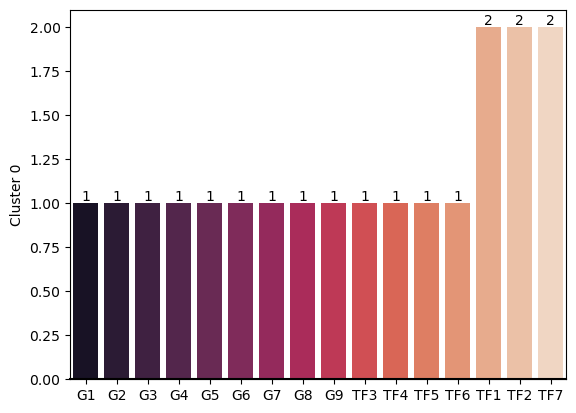

In [91]:
plot = sns.barplot(x=sort_index, y=encoded_df.max().sort_values()+1, palette="rocket")
plot.axhline(0, color="k", clip_on=False)
plot.set_ylabel("Cluster 0")
plot.bar_label(plot.containers[0], fontsize=10)

plt.show()

In [92]:
from collections import Counter
# Function to count strings in a row
def count_strings_in_row(row):
    return Counter(row)

def split_gene_clauses(model_logic_mtx, gene): 
    split_data = [item.split(" | ") for item in model_logic_mtx.loc[gene]]
    df = pd.DataFrame(split_data, index = model_logic_mtx.loc[gene].index)
    return(df)

def logic_clause_frequency(model_logic_mtx):
    logic_clause = pd.DataFrame()
    for i in model_logic_mtx.index:
        df = split_gene_clauses(model_logic_mtx, i)
        df = df.fillna(0)

        from collections import Counter
        # Function to count strings in a row
        def count_strings_in_row(row):
            return Counter(row)

        # Apply the function to each row and convert the result to a DataFrame
        row_counts = df.apply(lambda row: pd.Series(count_strings_in_row(row)), 
                                    axis=1).fillna(0)
        clauses = row_counts.sum()/len(df)
        logic_clause = pd.concat([logic_clause,clauses], ignore_index = True, axis = 1)
    logic_clause= logic_clause.fillna(0)
    logic_clause.columns = model_logic_mtx.index
    return(logic_clause)

Index(['(TF1)', '(TF2)', '(TF6)', '(!TF2 & TF3)', '(!TF1 & TF3)', '(TF4)',
       '(TF5)', '(!TF6)', '(!TF7)', '(0)'],
      dtype='object')

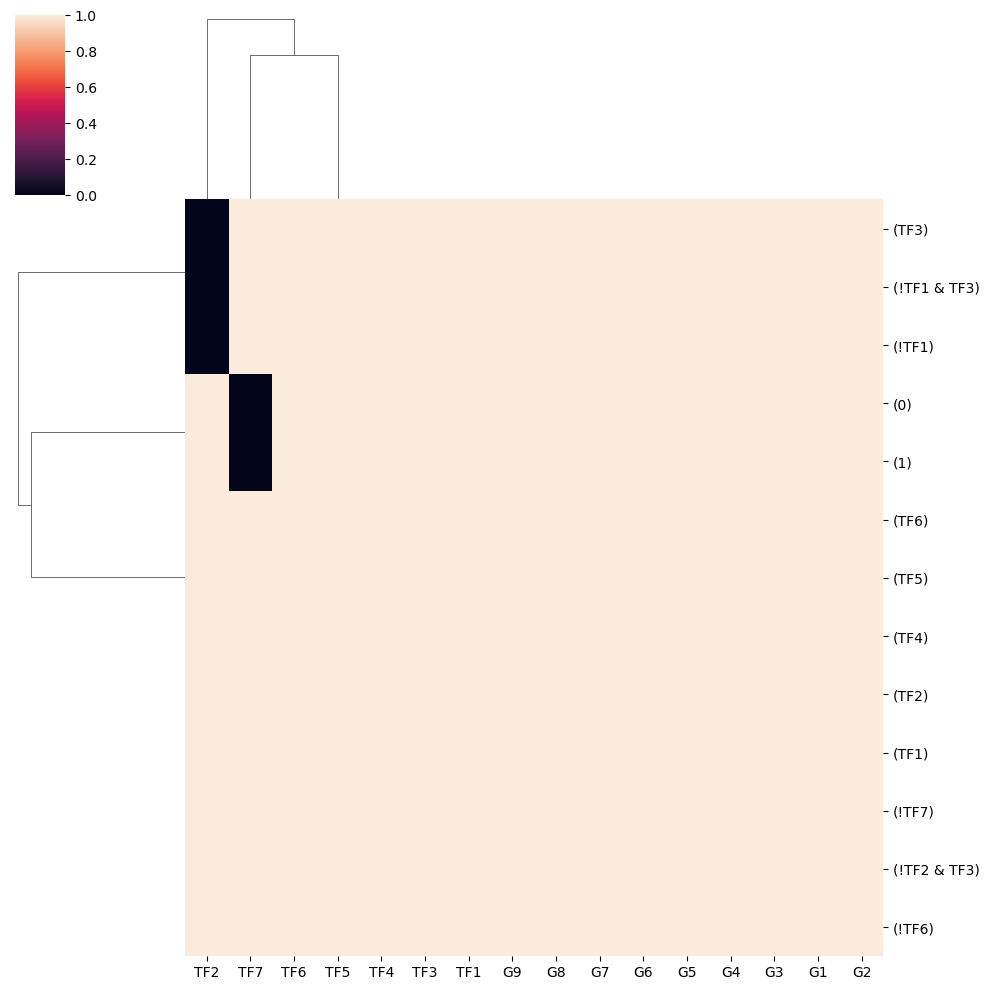

In [139]:
clause1 = logic_clause_frequency(model_logic[['bn4']])
clause2 = logic_clause_frequency(model_logic[['bn1']])
combined_index = clause1.index.union(clause2.index)

clause1 = clause1.reindex(combined_index).fillna(0)
clause2 = clause2.reindex(combined_index).fillna(0)
comparison = clause1 == clause2
#comparison = comparison.fillna(False)

sns.clustermap(comparison)

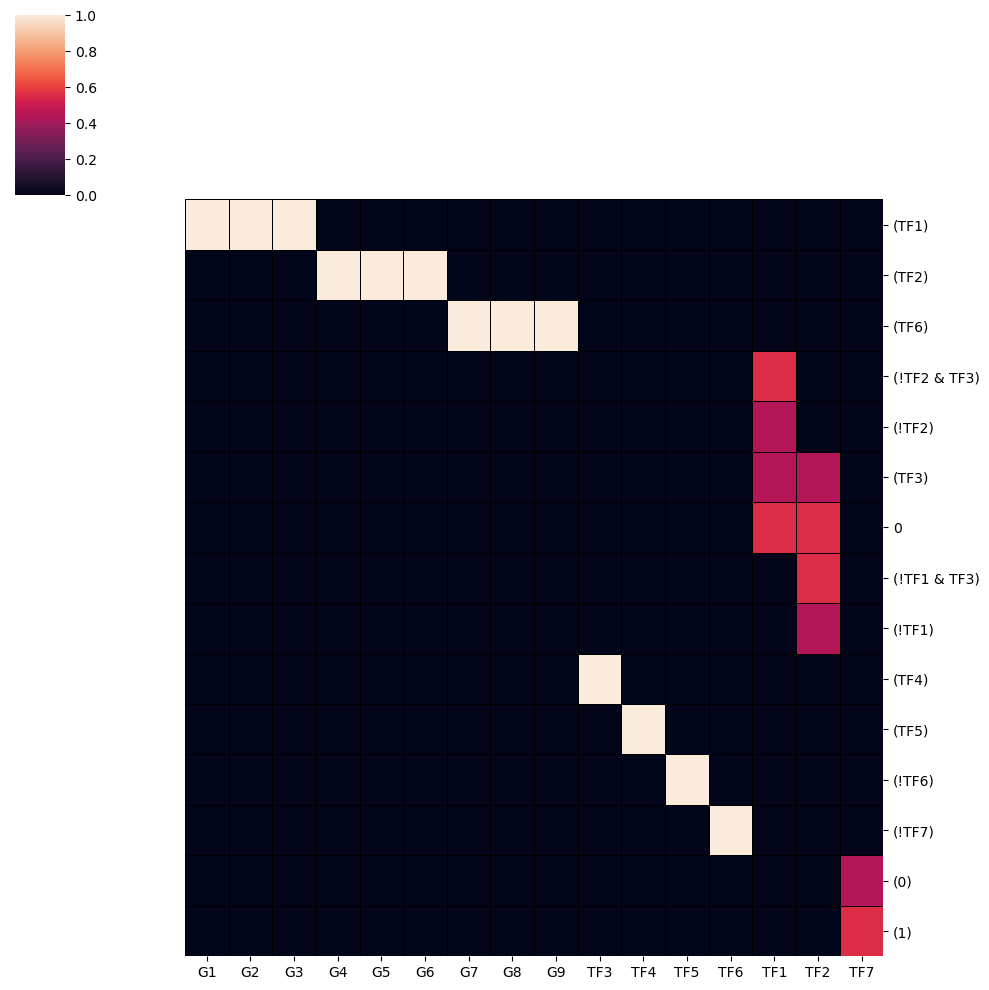

In [99]:
logic_cluase = logic_clause_frequency(model_logic)
sns.clustermap(logic_cluase[sort_index], 
               col_cluster = False, row_cluster = False, figsize = (10,10),
               linewidth = .5, linecolor = 'black')
plt.show()

,bn3,bn4,bn7,toy_reprogramming_1,bn5,bn0,bn2,bn6,bn1
G1,(TF1),(TF1),(TF1),(TF1),(TF1),(TF1),(TF1),(TF1),(TF1)
G2,(TF1),(TF1),(TF1),(TF1),(TF1),(TF1),(TF1),(TF1),(TF1)
G3,(TF1),(TF1),(TF1),(TF1),(TF1),(TF1),(TF1),(TF1),(TF1)
G4,(TF2),(TF2),(TF2),(TF2),(TF2),(TF2),(TF2),(TF2),(TF2)
G5,(TF2),(TF2),(TF2),(TF2),(TF2),(TF2),(TF2),(TF2),(TF2)
G6,(TF2),(TF2),(TF2),(TF2),(TF2),(TF2),(TF2),(TF2),(TF2)
G7,(TF6),(TF6),(TF6),(TF6),(TF6),(TF6),(TF6),(TF6),(TF6)
G8,(TF6),(TF6),(TF6),(TF6),(TF6),(TF6),(TF6),(TF6),(TF6)
G9,(TF6),(TF6),(TF6),(TF6),(TF6),(TF6),(TF6),(TF6),(TF6)
TF3,(TF4),(TF4),(TF4),(TF4),(TF4),(TF4),(TF4),(TF4),(TF4)


G1              (TF1)
G2              (TF1)
G3              (TF1)
G4              (TF2)
G5              (TF2)
G6              (TF2)
G7              (TF6)
G8              (TF6)
G9              (TF6)
TF1    (!TF2) | (TF3)
TF2      (!TF1 & TF3)
TF3             (TF4)
TF4             (TF5)
TF5            (!TF6)
TF6            (!TF7)
TF7               (0)
Name: bn3, dtype: object

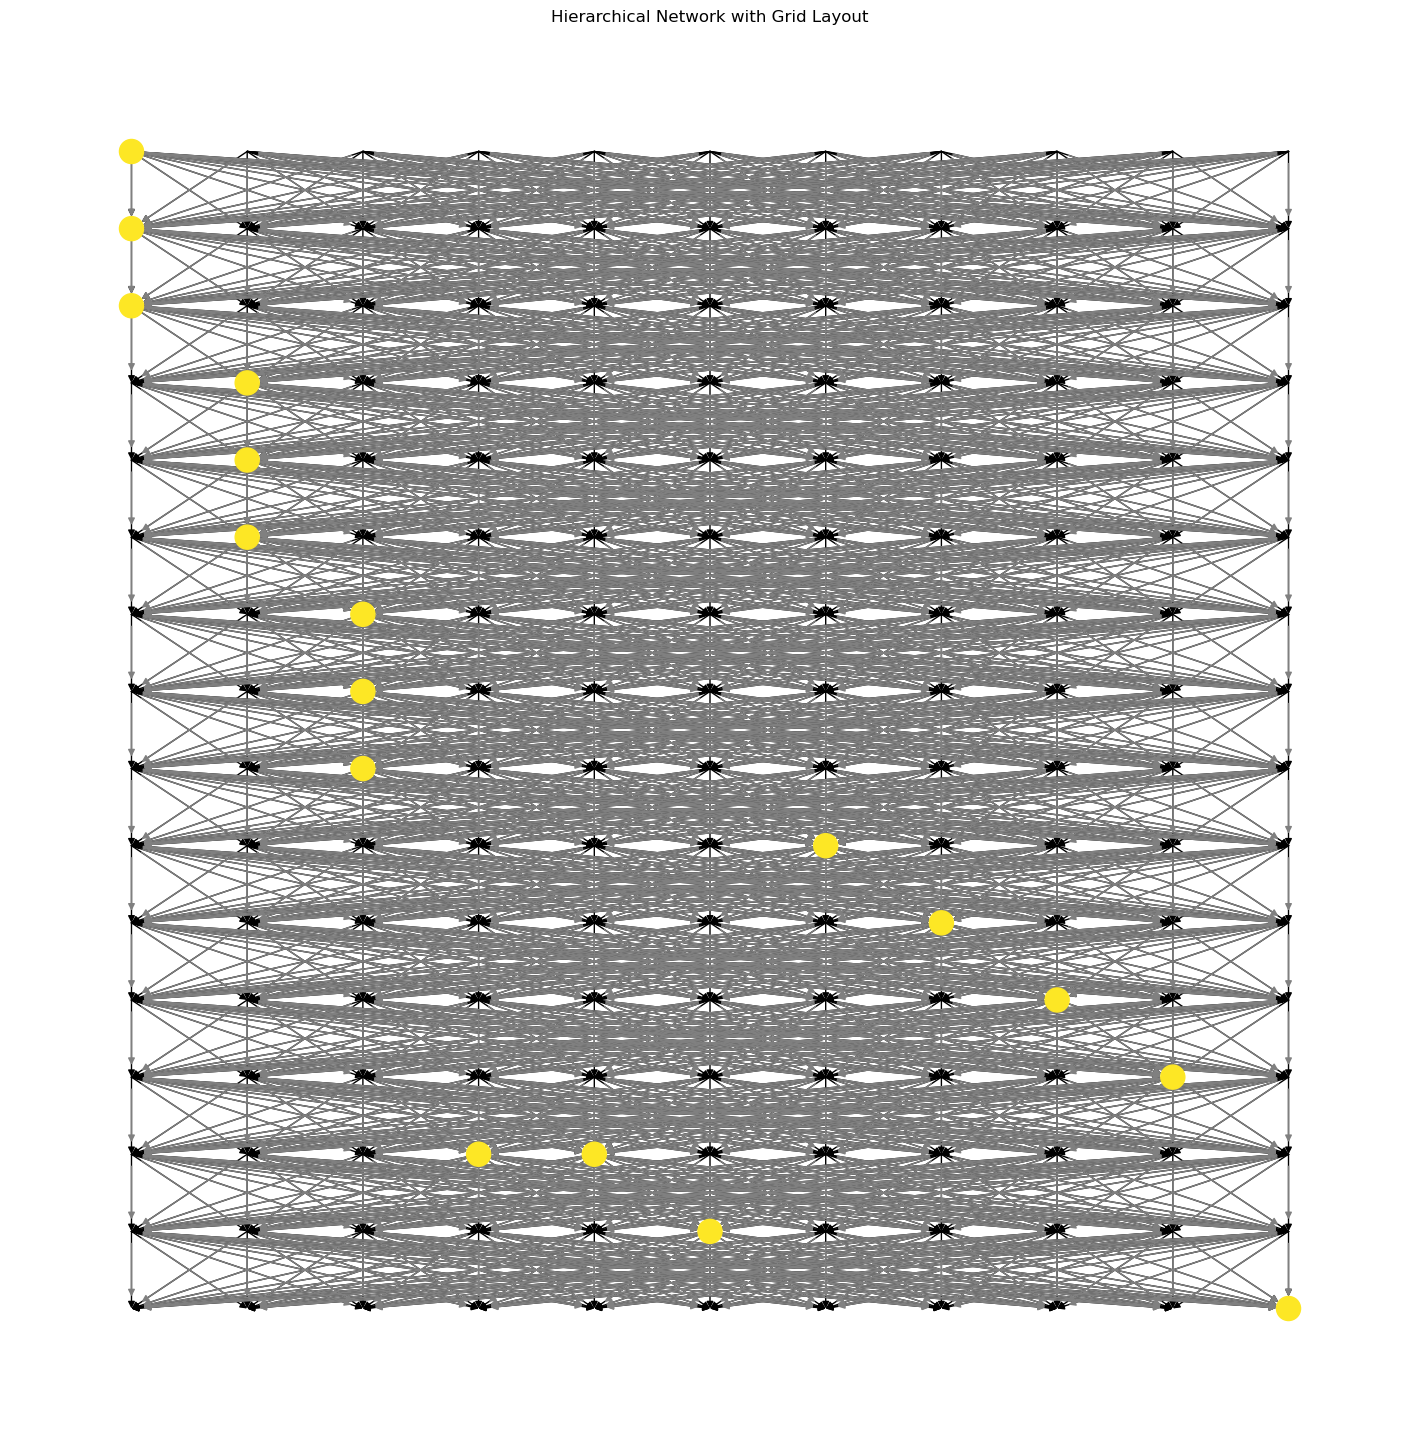

In [117]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# Sample DataFrame
logic_clause = logic_clause_frequency(model_logic.iloc[:,0:1])
logic_clause = logic_clause[sort_index]
data = logic_clause.transpose()
df = pd.DataFrame(data)

# Create a directed graph
G = nx.DiGraph()

# Add nodes and edges based on DataFrame
for level in range(len(df.index) - 1):
    for col in df.columns:
        parent = (level, col)
        child_level = level + 1
        for child_col in df.columns:
            child = (child_level, child_col)
            # Add edge with weight as the activity level of the child node
            G.add_edge(parent, child, weight=df.loc[df.index[child_level], child_col])

# Add node attributes for activity level
for level in range(len(df.index)):
    for col in df.columns:
        node = (level, col)
        G.nodes[node]['activity'] = df.loc[df.index[level], col]

# Identify nodes with activity level of 0
nodes_to_remove = [node for node in G.nodes if G.nodes[node]['activity'] == 0]

# Remove these nodes and their associated edges
#G.remove_nodes_from(nodes_to_remove)

# Position nodes in a grid layout
pos = {}
for level in range(len(df.index)):
    for i, col in enumerate(df.columns):
        pos[(level, col)] = (i, -level)

# Draw the network
plt.figure(figsize=(14, 14))

# Draw the nodes with sizes proportional to activity levels
node_sizes = [G.nodes[node]['activity'] * 300 for node in G.nodes]
nx.draw(G, pos, with_labels=False, node_size=node_sizes, node_color=node_sizes, font_weight='bold', node_shape='o')

# Draw the edges
nx.draw_networkx_edges(G, pos, arrowstyle='-|>', arrowsize=10, edge_color='gray')

# Draw the edge labels with weights
#edge_labels = nx.get_edge_attributes(G, 'weight')
#nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

# Set grid
#plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Set title
plt.title('Hierarchical Network with Grid Layout')

plt.show()